In [1]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import sys
import nbimporter

sys.path.append('../')
from module import sun_position
import Weather as WEA

Importing Jupyter notebook from ..\module\sun_position.ipynb
Importing Jupyter notebook from Weather.ipynb


# 太陽位置を計算するモジュール

## 1. Functions  

任意の時刻・緯度・経度における太陽高度角・太陽方位角を計算する。

### 入力値  



$Y$ is year / 西暦年  
$D$ is total day / 年通算日(1/1を $D=1$ とする), d    
$T_m$ is standard hour / 標準時, h  
$\Phi$ is latitude / 計算対象地点の緯度, deg  
$L$ is longitude / 計算対象地点の経度, deg    

### 出力値

$ h $ ：太陽高度角 (°)  
$ A $ ：太陽方位角 (°)  

#### Function

In [2]:
def solar_position(year, nday, tm, lat, lon):

    # longitude of the meridian (line) in Japan = 135.0 degree
    lons = 135.0

    # degree -> radian
    latrad = math.radians(lat)
    lonrad = math.radians(lon)
    lons_rad = math.radians(lons)
    
    hs, A = sun_position.calc_solar_position(year, nday, tm, latrad, lonrad, lons_rad, 'AKASAKA')

    # equation time, h & declination, rad
#    et_hour, dlt = \
#    sun_position.get_eqation_of_time_and_declination_AKASAKA(year, nday)

    # hour angle / 時角, rad
#    hour_angle = sun_position.calc_Tdt(lonrad, et_hour, tm, lons_rad)
    
    # solar altitude / 太陽高度, rad, -, -
#    hs, sin_hs, cos_hs = sun_position.calc_hs(latrad, dlt, hour_angle)
    
    # solar azimuth / 太陽方位角, rad
#    A = sun_position.calc_Azs(latrad, dlt, hour_angle, hs)

    return math.degrees(hs), math.degrees(A)

#### Example

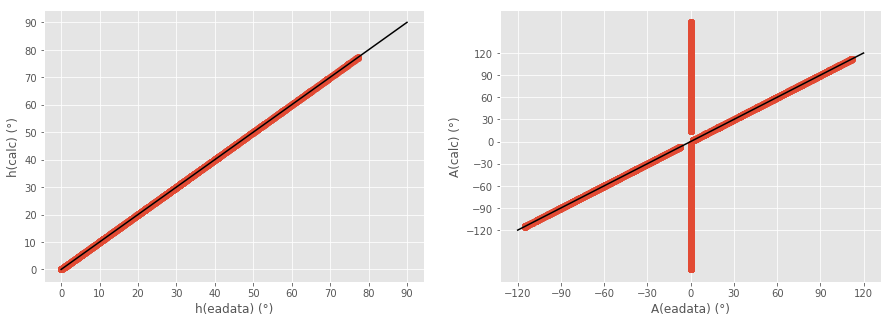

In [7]:
if __name__ == '__main__':

    location = '3639999'               #東京ID
    year = 1995                        #西暦年
    lat = 35. + 41.2 / 60.             #計算対象地点の緯度 (°)  
    lon = 139. + 45.9 / 60.            #計算対象地点の経度 (°)  

    sp_result = np.empty((5,8760))

    for i in range(0, 8760):
        nday = int((i + 1.) / 24.) + 1.
        tm = ((i + 1.) / 24. - int((i + 1.) / 24.)) * 24.
        sp_result[0][i] = i + 1.                                           #年通算時間
        sp_result[1][i] = int((i + 1.) / 24.) + 1.                         #年通算日
        sp_result[2][i] = ((i + 1.) / 24. - int((i + 1.) / 24.)) * 24.     #時刻
#        sp_result[3][i] = solar_position(year, nday, tm, lat, lon)[0]                         #太陽高度角
#        sp_result[4][i] = solar_position(year, nday, tm, lat, lon)[1]                         #太陽方位角
        hs, A = sun_position.calc_solar_position(
            year, nday, tm, math.radians(lat), math.radians(lon), math.radians(135.0), 'AKASAKA'
        )
        sp_result[3][i], sp_result[4][i] = math.degrees(hs), math.degrees(A)

    #確認用気象データ読込
    wc = WEA.WeatherConfirm(location)

    #グラフの描画
    graph_num = 2
    ax = np.empty(graph_num, dtype = np.object)
    fig = plt.figure(figsize = (15, 5 * ((graph_num + 1) // 2)))
    plt.style.use('ggplot')

    gpc = 'C0'
    gxd = [[[r.w_h for r in wc.rows], [0,90]], [[r.w_A for r in wc.rows], [-120,120]]]
    gyd = [[sp_result[3][0:8760], [0,90]], [sp_result[4][0:8760], [-120,120]]]
    gxl = ['h(eadata) (°)','A(eadata) (°)']
    gyl = ['h(calc) (°)', 'A(calc) (°)']
    gxt = [[10 * i for i in range(10)], [30 * (i - 4) for i in range(9)]]
    gyt = [[10 * i for i in range(10)], [30 * (i - 4) for i in range(9)]]

    for i in range(graph_num):   
        ax[i] = fig.add_subplot((graph_num + 1) // 2, 2, i + 1)
        ax[i].scatter(gxd[i][0], gyd[i][0], color = gpc)
        ax[i].plot(gxd[i][1], gyd[i][1], color = (0,0,0))
        ax[i].set_xticks(gxt[i])
        ax[i].set_yticks(gyt[i])
        ax[i].set_xlabel(gxl[i], fontsize = 12)
        ax[i].set_ylabel(gyl[i], fontsize = 12)

    plt.show()